In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Open Data csv file
filename = "data_altered.csv"
data = pd.read_csv(filename,low_memory=False, delimiter=";")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624790 entries, 0 to 2624789
Data columns (total 83 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   ORD                               int64  
 1   THIRD                             int64  
 2   CLUB_DT                           int64  
 3   PROD                              object 
 4   PROD_DESCR                        object 
 5   PROD_CAT_H1                       float64
 6   MARKET                            object 
 7   CHANNEL                           int64  
 8   THIRD_CAT1_DESCR                  object 
 9   THIRD_STATUS                      int64  
 10  THIRD_STATUS_DESCR                object 
 11  CLUB_DT_DISP                      object 
 12  MC_IC_ID                          float64
 13  MASTER_CONTROL_ID                 float64
 14  MASTER_CONTROL                    object 
 15  MANAGED_BY_ID                     float64
 16  LOCALLY_MANAGED_BY_ID             fl

## Preparation et exploration du dataset

In [3]:
# Feature Selection
Features = ['ORD','MAIN_DATE','PROD_INT','PROD_CAT_H5_DESCR','UNIT_PRICE','TOTAL_OF_QUANTITY','NS','Allowances','THIRD','THIRD_STATUS','THIRD_STATUS_DESCR','THIRD_CAT1_DESCR','PROD','PROD_DESCR']
data_f = data[Features]

# Count NA values
data_f.isna().sum()

ORD                        0
MAIN_DATE                  0
PROD_INT              491982
PROD_CAT_H5_DESCR     488317
UNIT_PRICE                 0
TOTAL_OF_QUANTITY     491982
NS                         0
Allowances                 0
THIRD                      0
THIRD_STATUS               0
THIRD_STATUS_DESCR         0
THIRD_CAT1_DESCR           0
PROD                  491982
PROD_DESCR            491982
dtype: int64

In [4]:
#removing rows not containing a quantity information to eliminate NA VALUES:
df=pd.DataFrame(data_f.dropna(subset=['TOTAL_OF_QUANTITY']))
df.isna().sum()

ORD                   0
MAIN_DATE             0
PROD_INT              0
PROD_CAT_H5_DESCR     0
UNIT_PRICE            0
TOTAL_OF_QUANTITY     0
NS                    0
Allowances            0
THIRD                 0
THIRD_STATUS          0
THIRD_STATUS_DESCR    0
THIRD_CAT1_DESCR      0
PROD                  0
PROD_DESCR            0
dtype: int64

In [5]:
# Convert MAIN_DATE' column to datetime format with 'errors' parameter
df['MAIN_DATE'] = pd.to_datetime(df['MAIN_DATE'], format='%Y%m%d%H%M%S', errors='coerce')
# extracting Year and month from Main date column
df['YEAR']=df['MAIN_DATE'].dt.year
df['MONTH']=df['MAIN_DATE'].dt.month
df = df.sort_values(by='MAIN_DATE', ascending=False)

In [6]:
# Converting columns to numbers format: 
floats = ['UNIT_PRICE', 'NS', 'Allowances']
for float in floats:
    if  df[float].dtype != np.float64:
        df[float] = df[float].str.replace(',', '.')
        df[float] = df[float].astype('float64')

df

,ORD,MAIN_DATE,PROD_INT,PROD_CAT_H5_DESCR,UNIT_PRICE,TOTAL_OF_QUANTITY,NS,Allowances,THIRD,THIRD_STATUS,THIRD_STATUS_DESCR,THIRD_CAT1_DESCR,PROD,PROD_DESCR,YEAR,MONTH
1646968,152189328,2018-12-31,8880.81,Coffee Capsules,0.3200,100.0,32.00,0.0,3627629,3,Inactive automatic (365 days),OFFICE,8880.81,BOITE Espresso Forte 50 capsules,2018,12
1709521,150997681,2018-12-31,8880.81,Coffee Capsules,0.2912,50.0,14.56,0.0,7529215,1,Active,OFFICE,8880.81,BOITE Espresso Forte 50 capsules,2018,12
1932796,152151174,2018-12-31,8884.81,Coffee Capsules,0.3200,100.0,32.00,0.0,1397795,1,Active,OTHER/PRIVATE,8884.81,BOITE Espresso Decaffeinato 50 capsules,2018,12
1441510,151142462,2018-12-31,5073/100,Les Collections,0.9600,-3.0,-2.88,0.0,7529084,1,Active,OFFICE,5073/100,100 Mélangeurs,2018,12
474211,151951310,2018-12-31,8882.81,Coffee Capsules,0.3200,750.0,240.00,0.0,7392300,1,Active,HORECA,8882.81,BOITE Ristretto 50 capsules,2018,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165505,138163885,2018-01-02,8760.0,Coffee Capsules,0.3000,500.0,150.00,0.0,5702161,3,Inactive automatic (365 days),HORECA,8760.0,BOITE Espresso Decaffeinato 50 caps,2018,1
551088,138163914,2018-01-02,3519/bulk,Les Collections,4.5000,1.0,4.50,0.0,5629637,1,Active,HORECA,3519/BULK,Sachets de sucre 4g x 300,2018,1
551103,138160907,2018-01-02,60091,Les Collections,3.0000,10.0,30.00,0.0,4494939,1,Active,HORECA,60091,"Hot chocolate ""Le Chocolat"" (10x17gr)",2018,1
165479,138180354,2018-01-02,8760.0,Coffee Capsules,0.3200,300.0,96.00,0.0,2448191,1,Active,HORECA,8760.0,BOITE Espresso Decaffeinato 50 caps,2018,1


In [7]:
#new df based on NS (amount)
sales = pd.DataFrame(df[df["NS"]>0])
rebates = df[df["NS"]<0]

sales.head()

,ORD,MAIN_DATE,PROD_INT,PROD_CAT_H5_DESCR,UNIT_PRICE,TOTAL_OF_QUANTITY,NS,Allowances,THIRD,THIRD_STATUS,THIRD_STATUS_DESCR,THIRD_CAT1_DESCR,PROD,PROD_DESCR,YEAR,MONTH
1646968,152189328,2018-12-31,8880.81,Coffee Capsules,0.3200,100.0,32.00,0.0,3627629,3,Inactive automatic (365 days),OFFICE,8880.81,BOITE Espresso Forte 50 capsules,2018,12
1709521,150997681,2018-12-31,8880.81,Coffee Capsules,0.2912,50.0,14.56,0.0,7529215,1,Active,OFFICE,8880.81,BOITE Espresso Forte 50 capsules,2018,12
1932796,152151174,2018-12-31,8884.81,Coffee Capsules,0.3200,100.0,32.00,0.0,1397795,1,Active,OTHER/PRIVATE,8884.81,BOITE Espresso Decaffeinato 50 capsules,2018,12
474211,151951310,2018-12-31,8882.81,Coffee Capsules,0.3200,750.0,240.00,0.0,7392300,1,Active,HORECA,8882.81,BOITE Ristretto 50 capsules,2018,12
786670,152181118,2018-12-31,8882.81,Coffee Capsules,0.3900,50.0,19.50,0.0,4257584,1,Active,HORECA,8882.81,BOITE Ristretto 50 capsules,2018,12


In [8]:
Sales_per_category = sales.groupby('PROD_CAT_H5_DESCR')['NS'].sum()*1
Sales_per_category = Sales_per_category.sort_values(ascending=False)
pd.options.display.float_format = '{:.2f}'.format

Sales_per_category

PROD_CAT_H5_DESCR
Coffee Capsules          123151778.86
Machines                  15853069.44
Les Collections            6196637.45
Machine Accessories        1924934.04
Services & Rental           458822.43
Other                       398550.23
Technical Parts             155810.81
Service & Rental             19090.24
Sales Support                 7761.30
Markets Local Products        7207.50
Other Deductions              1278.15
Promotions                     559.59
B2B Services                   108.00
Name: NS, dtype: float64

In [9]:
#Summary 2018 : 

total_sales = sum(sales['NS'])
count_orders = sales['ORD'].nunique()
count_customers = sales['THIRD'].nunique()

print("Total des ventes en 2018 : {:.0f}".format(total_sales))
print("Total des commandes en 2018 : {:.0f}".format(count_orders))
print("Nombre des clients en 2018 : {:.0f}".format(count_customers))

Total des ventes en 2018 : 148175608
Total des commandes en 2018 : 354009
Nombre des clients en 2018 : 56203


In [10]:
Sales_per_product = sales.groupby(['PROD_INT','PROD_DESCR'])['NS'].sum().round(2)
Sales_per_product = Sales_per_product.sort_values(ascending=False)

Sales_per_product[:30]

PROD_INT    PROD_DESCR                             
8880.81     BOITE Espresso Forte 50 capsules          18811130.64
8881.81     BOITE Espresso Leggero 50 capsules        14869591.46
8892.81     BOITE Lungo Leggero 50 capsules           13841202.03
8891.81     BOITE Lungo Forte 50 capsules             11863311.28
8882.81     BOITE Ristretto 50 capsules                7654803.80
8883.81     BOITE Espresso Origin Brazil               4938522.71
ZN100/EUR1  Zenius non Neslink                         4572150.14
CS203/EUR1  Gemini CS203 EUR NBCS No Neslink           4555663.59
8884.81     BOITE Espresso Decaffeinato 50 capsules    4370059.84
8886.81     BOITE Lungo Origin Guatemala               3834945.54
8893.81     BOITE Ristretto Intenso 50 capsules        3326239.94
8894.81     BOITE Ristretto Origin India               3179495.41
8570.0      BOITE Espresso Forte 50 caps               3047798.59
8610.0      BOITE Lungo Leggero 50 caps                2751224.00
8590.0      BOITE Espres

In [11]:
Sales_per_month = sales.groupby('MONTH')['NS'].sum()
Sales_per_month 

MONTH
1    11807044.00
2    11207903.07
3    14358539.37
4    12288290.01
5    10843839.16
6    13770521.43
7    11480849.14
8     8464455.27
9    13267606.80
10   15211317.45
11   14104501.45
12   11370740.88
Name: NS, dtype: float64

In [12]:
Sales_per_customer_category= sales.groupby('THIRD_CAT1_DESCR')['NS'].sum()
Sales_per_customer_category.sort_values(ascending=False)

THIRD_CAT1_DESCR
OFFICE             98949324.68
HORECA             43967616.95
DROM COM            4210163.82
OTHER/PRIVATE        370454.56
Office B2C           277730.19
Foodservice          221287.09
Boutique              77754.95
Household             65320.37
Coffee Community      26464.93
Nestlé Employee        5690.80
TRAVEL                 3799.70
Name: NS, dtype: float64

In [13]:
Sales_per_customer = sales.groupby('THIRD')['NS'].sum()
Sales_per_customer.sort_values(ascending=False)

THIRD
6528527   1514984.37
6706336   1016841.85
6706298    805459.28
6176261    386413.72
6527935    322511.79
             ...    
5707831         4.08
5810738         4.00
7085281         2.88
3749480         2.13
7088444         2.00
Name: NS, Length: 56203, dtype: float64

In [14]:
quantiles = Sales_per_customer.quantile([0.25, 0.5, 0.75])

print("Quantiles:")
print(quantiles)

Quantiles:
0.25    496.00
0.50   1106.00
0.75   2452.10
Name: NS, dtype: float64


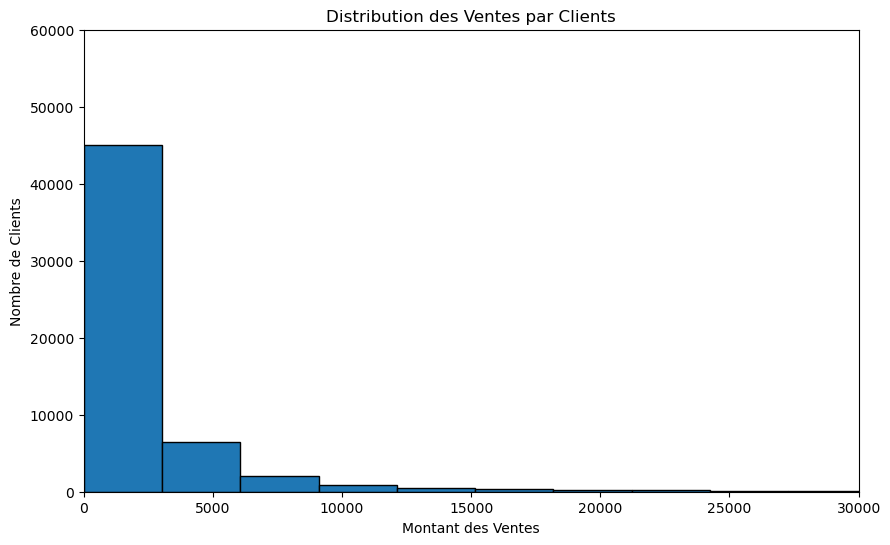

In [15]:
# Créer un histogramme pour visualiser la distribution des ventes par clients
plt.figure(figsize=(10, 6))
plt.hist(Sales_per_customer, bins=500, edgecolor='black')
plt.xlabel('Montant des Ventes')
plt.ylabel('Nombre de Clients')
plt.title('Distribution des Ventes par Clients')

# Spécifier le format des étiquettes sur l'axe x (sans notation scientifique)

plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 30000)
plt.ylim(0, 60000)

plt.show()

In [16]:
#panier moyen général: 
sum_sales = sum(sales['NS'])
count_orders = df['ORD'].nunique()
panier_moyen = sum_sales/count_orders
print("Panier moyen général:",panier_moyen)

Panier moyen général: 374.71451270083116


In [17]:
#panier moyen par client
sales_per_customer = sales.groupby('THIRD')['NS'].sum()
number_orders_per_cust = sales.groupby(['THIRD', 'ORD'])['NS'].count().groupby('THIRD').size()
ave_panier = sales_per_customer/number_orders_per_cust
ave_panier


THIRD
800        113.36
890         67.01
1975        52.42
5817        84.00
7207       116.07
            ...  
7767881    257.50
7767884     68.00
7767897    161.33
7767901    420.00
7768244   1038.64
Name: NS, Length: 56203, dtype: float64

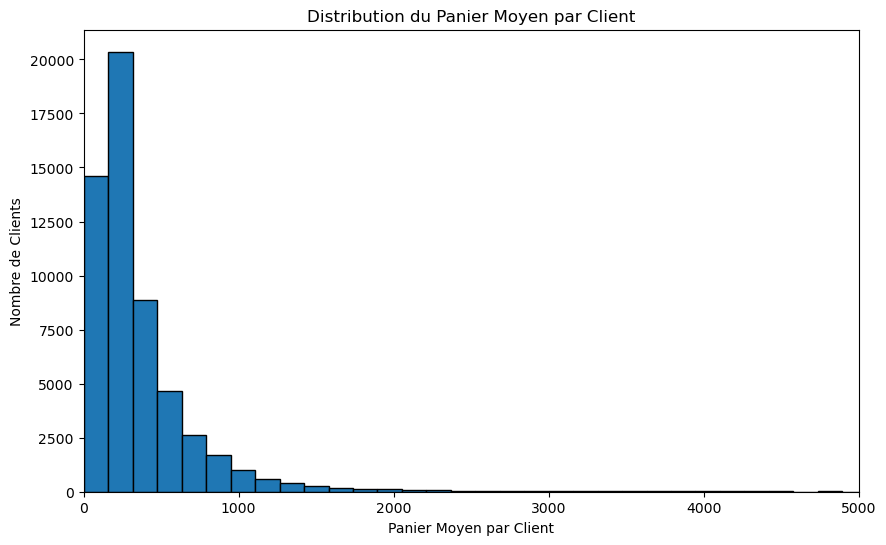

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(ave_panier, bins=300, edgecolor='black')
plt.xlabel('Panier Moyen par Client')
plt.ylabel('Nombre de Clients')
plt.title('Distribution du Panier Moyen par Client')
plt.xlim(0, 5000)

plt.show()

In [19]:
Sales_per_customer_status= sales.groupby('THIRD_STATUS_DESCR')['NS'].sum()
Sales_per_customer_status.sort_values(ascending=False)

THIRD_STATUS_DESCR
Active                           112930625.55
Inactive automatic (365 days)     34450321.52
Deletion due to inactivity          606722.95
Inactive unclassified               164461.42
Inactive doublon                     11184.35
Active no mailing                     8011.92
Prospects                             2609.33
Inactive pb serv./price/system        1671.00
Name: NS, dtype: float64

In [20]:
# keep only the most recent date of purchase
sales['rank'] = sales.sort_values(['THIRD','MAIN_DATE']).groupby(['THIRD'])['MAIN_DATE'].rank(method='min').astype(int)
sales_rec = pd.DataFrame(sales[sales['rank']==1])
sales

,ORD,MAIN_DATE,PROD_INT,PROD_CAT_H5_DESCR,UNIT_PRICE,TOTAL_OF_QUANTITY,NS,Allowances,THIRD,THIRD_STATUS,THIRD_STATUS_DESCR,THIRD_CAT1_DESCR,PROD,PROD_DESCR,YEAR,MONTH,rank
1646968,152189328,2018-12-31,8880.81,Coffee Capsules,0.32,100.00,32.00,0.00,3627629,3,Inactive automatic (365 days),OFFICE,8880.81,BOITE Espresso Forte 50 capsules,2018,12,26
1709521,150997681,2018-12-31,8880.81,Coffee Capsules,0.29,50.00,14.56,0.00,7529215,1,Active,OFFICE,8880.81,BOITE Espresso Forte 50 capsules,2018,12,9
1932796,152151174,2018-12-31,8884.81,Coffee Capsules,0.32,100.00,32.00,0.00,1397795,1,Active,OTHER/PRIVATE,8884.81,BOITE Espresso Decaffeinato 50 capsules,2018,12,8
474211,151951310,2018-12-31,8882.81,Coffee Capsules,0.32,750.00,240.00,0.00,7392300,1,Active,HORECA,8882.81,BOITE Ristretto 50 capsules,2018,12,73
786670,152181118,2018-12-31,8882.81,Coffee Capsules,0.39,50.00,19.50,0.00,4257584,1,Active,HORECA,8882.81,BOITE Ristretto 50 capsules,2018,12,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768963,137790962,2018-01-02,5073/100,Les Collections,0.96,10.00,9.60,0.00,6169925,1,Active,OFFICE,5073/100,100 Mélangeurs,2018,1,1
165505,138163885,2018-01-02,8760.0,Coffee Capsules,0.30,500.00,150.00,0.00,5702161,3,Inactive automatic (365 days),HORECA,8760.0,BOITE Espresso Decaffeinato 50 caps,2018,1,1
551088,138163914,2018-01-02,3519/bulk,Les Collections,4.50,1.00,4.50,0.00,5629637,1,Active,HORECA,3519/BULK,Sachets de sucre 4g x 300,2018,1,1
551103,138160907,2018-01-02,60091,Les Collections,3.00,10.00,30.00,0.00,4494939,1,Active,HORECA,60091,"Hot chocolate ""Le Chocolat"" (10x17gr)",2018,1,1


## RFM et segmentation - KMeans

In [21]:
sales_rec['recency'] = (sales_rec['MAIN_DATE'] - pd.to_datetime(min(sales_rec['MAIN_DATE']))).dt.days
sales_rec.sample(10)

,ORD,MAIN_DATE,PROD_INT,PROD_CAT_H5_DESCR,UNIT_PRICE,TOTAL_OF_QUANTITY,NS,Allowances,THIRD,THIRD_STATUS,THIRD_STATUS_DESCR,THIRD_CAT1_DESCR,PROD,PROD_DESCR,YEAR,MONTH,rank,recency
2369598,140281394,2018-03-01,5003/1,Les Collections,32.00,1.00,32.00,0.00,7343797,3,Inactive automatic (365 days),OFFICE,5003/1,Boîte de présentation capsules,2018,3,1,58
1509857,150182967,2018-11-22,70033,Other,1100.00,1.00,1100.00,0.00,7692776,1,Active,HORECA,INST/AGUILA,Frais instal/ désinstal AGUILA,2018,11,1,324
287380,141379726,2018-03-29,CS203/EUR1,Machines,1095.00,1.00,1095.00,0.00,7369078,3,Inactive automatic (365 days),HORECA,CS203/EUR1,Gemini CS203 EUR NBCS No Neslink,2018,3,1,86
971051,140073707,2018-02-22,8780.0,Coffee Capsules,0.36,200.00,72.00,0.00,5905938,1,Active,OFFICE,8780.0,BOITE Lungo Origin Guatemala 50 caps,2018,2,1,51
1510405,142628771,2018-05-03,ZN100/EUR1,Machines,299.00,1.00,299.00,0.00,7415134,3,Inactive automatic (365 days),OFFICE,ZN100/EUR1,Zenius non Neslink,2018,5,1,121
429339,138746585,2018-01-18,8869.0,Coffee Capsules,0.28,100.00,28.00,0.00,6761931,3,Inactive automatic (365 days),OFFICE,8869.0,BOITE Espresso Vanilla 50 caps,2018,1,1,16
403722,138751593,2018-01-18,8610.0,Coffee Capsules,0.32,50.00,16.00,0.00,1404931,1,Active,OTHER/PRIVATE,8610.0,BOITE Lungo Leggero 50 caps,2018,1,1,16
1753362,139257717,2018-01-30,5072/50,Les Collections,2.50,5.00,12.50,0.00,5361087,1,Active,OFFICE,5072/50,50 gobelets carton 2.5dl,2018,1,1,28
1887990,138475432,2018-01-10,8760.0,Coffee Capsules,0.42,100.00,42.00,0.00,1612353,1,Active,OFFICE,8760.0,BOITE Espresso Decaffeinato 50 caps,2018,1,1,8
444949,140377655,2018-03-05,8891.81,Coffee Capsules,0.28,200.00,56.00,0.00,7340068,1,Active,OFFICE,8891.81,BOITE Lungo Forte 50 capsules,2018,3,1,62


In [22]:
freq = sales.groupby('THIRD')['ORD'].count()
sales_freq = pd.DataFrame(freq).reset_index()
sales_freq.columns = ['THIRD','frequency']
sales_freq

,THIRD,frequency
0,800,6
1,890,22
2,1975,21
3,5817,33
4,7207,31
...,...,...
56198,7767881,4
56199,7767884,4
56200,7767897,6
56201,7767901,5


In [23]:
rec_freq=sales_freq.merge(sales_rec,on='THIRD')
rec_freq

,THIRD,frequency,ORD,MAIN_DATE,PROD_INT,PROD_CAT_H5_DESCR,UNIT_PRICE,TOTAL_OF_QUANTITY,NS,Allowances,THIRD_STATUS,THIRD_STATUS_DESCR,THIRD_CAT1_DESCR,PROD,PROD_DESCR,YEAR,MONTH,rank,recency
0,800,6,147072142,2018-09-01,7702.20,Coffee Capsules,0.39,40.00,14.79,0.00,1,Active,OFFICE,7702.20,Ristretto Decaffeinato New,2018,9,1,242
1,800,6,147072142,2018-09-01,7704.20,Coffee Capsules,0.35,70.00,23.22,0.00,1,Active,OFFICE,7704.20,Ristretto New,2018,9,1,242
2,890,22,144384089,2018-06-20,7413.20,Coffee Capsules,0.35,20.00,6.64,0.00,3,Inactive automatic (365 days),Foodservice,7413.20,Capriccio,2018,6,1,169
3,890,22,144384089,2018-06-20,7530.20,Coffee Capsules,0.42,20.00,7.96,0.00,3,Inactive automatic (365 days),Foodservice,7530.20,Dulsao Do Brasil,2018,6,1,169
4,890,22,144384089,2018-06-20,3253,Les Collections,7.50,1.00,7.11,0.00,3,Inactive automatic (365 days),Foodservice,3253,Carrés de chocolat noir,2018,6,1,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289752,7768244,15,152055500,2018-12-28,BASE CABINET,Machine Accessories,1040.00,1.00,1040.00,0.00,3,Inactive automatic (365 days),OFFICE,BASE CABINET,Base Cabinet,2018,12,1,360
289753,7768244,15,152055868,2018-12-28,BASE CABINET,Machine Accessories,1040.00,1.00,1040.00,0.00,3,Inactive automatic (365 days),OFFICE,BASE CABINET,Base Cabinet,2018,12,1,360
289754,7768244,15,152054927,2018-12-28,30073,Machine Accessories,85.50,4.00,342.00,0.00,3,Inactive automatic (365 days),OFFICE,30073,Support bras NAYAX,2018,12,1,360
289755,7768244,15,152055164,2018-12-28,CS203/EUR1,Machines,1095.00,1.00,1095.00,0.00,3,Inactive automatic (365 days),OFFICE,CS203/EUR1,Gemini CS203 EUR NBCS No Neslink,2018,12,1,360


In [24]:
m = rec_freq.groupby('THIRD')['NS'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['THIRD','monetary_value']

In [25]:
rfm = m.merge(rec_freq, on='THIRD')

In [26]:
finaldf = rfm[['THIRD','recency','frequency','monetary_value']]

finaldf

,THIRD,recency,frequency,monetary_value
0,800,242,6,38.01
1,800,242,6,38.01
2,890,169,22,96.59
3,890,169,22,96.59
4,890,169,22,96.59
...,...,...,...,...
289752,7768244,360,15,14541.00
289753,7768244,360,15,14541.00
289754,7768244,360,15,14541.00
289755,7768244,360,15,14541.00


recency: 


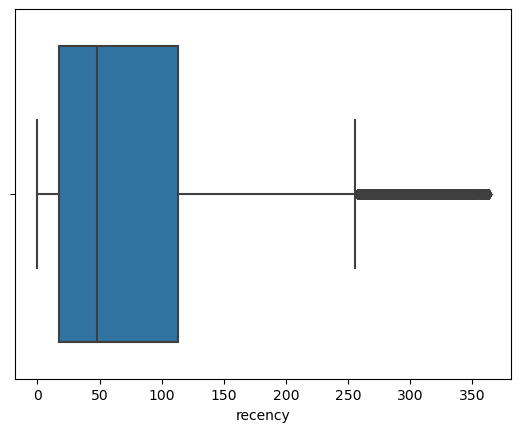

frequency: 


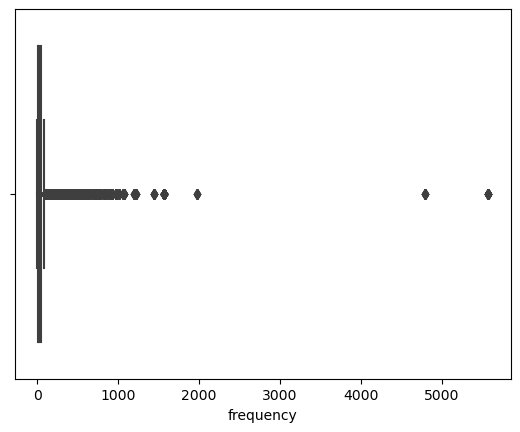

monetary_value: 


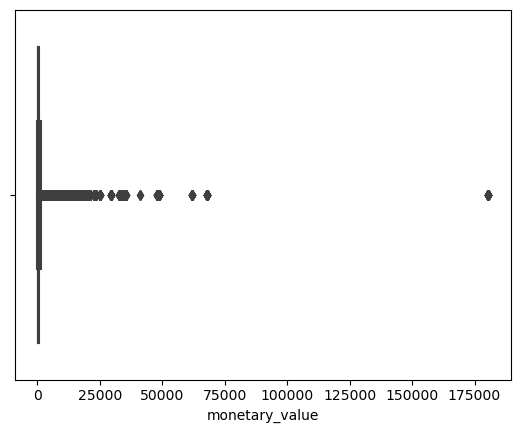

In [27]:
#creating boxplots
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()

In [28]:
# remove the THIRD column to calculate Z-score
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers for z-score >3
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

new_df.head()

,recency,frequency,monetary_value
0,242,6,38.01
1,242,6,38.01
2,169,22,96.59
3,169,22,96.59
4,169,22,96.59


In [29]:
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

Text(0, 0.5, 'Inertia')

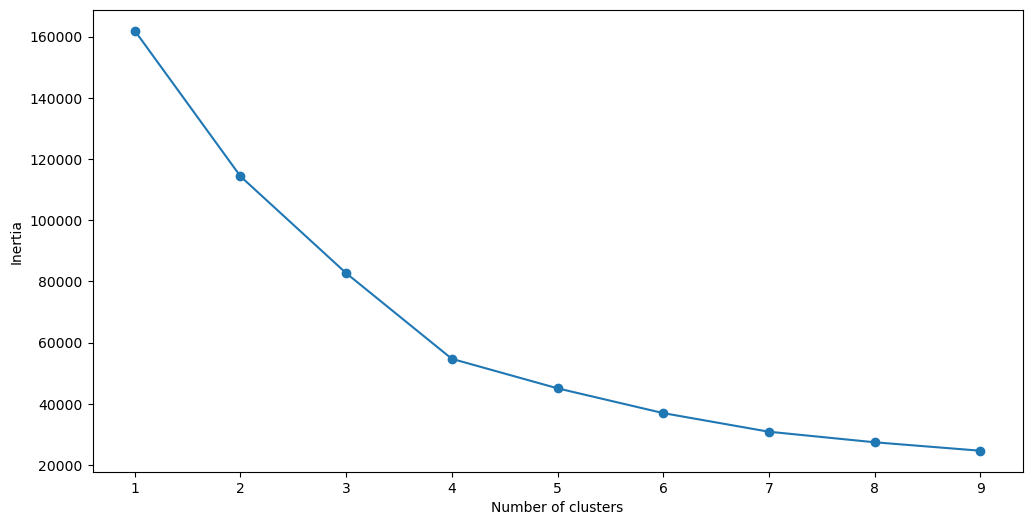

In [30]:
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++', n_init=10)
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [31]:
# First, build a model with 4 clusters
kmeans = KMeans( n_clusters = 4, init='k-means++', n_init=10)
kmeans.fit(scaled_features)

KMeans(n_clusters=4)

In [32]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.49663081086456906


In [33]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

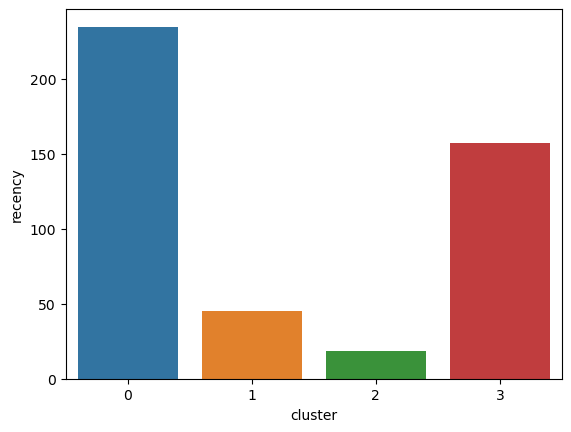

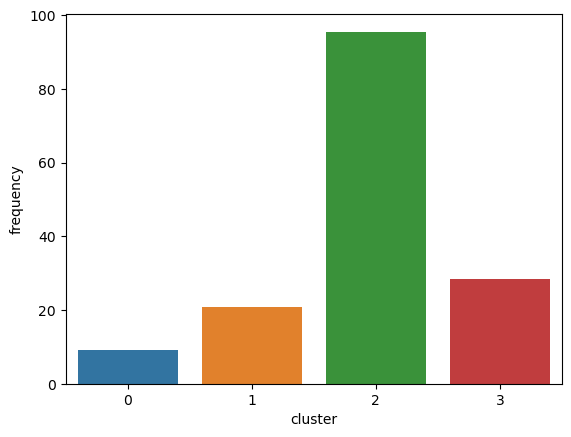

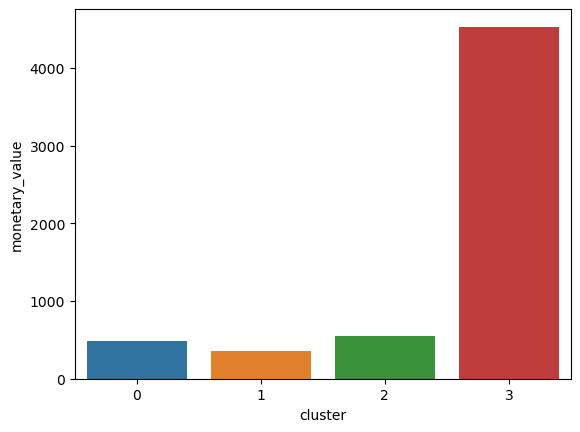

In [34]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()

In [35]:
frame.groupby('cluster')[['recency','frequency','monetary_value']].mean()

,recency,frequency,monetary_value
cluster,,,
0,234.75,9.17,491.63
1,44.91,20.92,358.84
2,18.54,95.52,547.36
3,157.13,28.46,4533.05
